In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(ch:wrangling_co2)=
# Example: Wrangling CO<sub>2</sub> Measurements from the Mauna Loa Observatory  

We saw in {numref}`Chapter %s <ch:data_scope>` that the [National Oceanic and Atmospheric Administration (NOAA)](https://www.noaa.gov/) monitors CO<sub>2</sub> concentrations in the air at the [Mauna Loa Observatory](https://gml.noaa.gov/obop/mlo/). We continue with this example and use it to introduce how to make data-quality checks, handle missing values, transform features, and reshape tables.
These data are in the file _data/co2_mm_mlo.txt_. Let's begin by figuring out the formatting, encoding, and size of the source before we load it into a dataframe (see {numref}`Chapter %s <ch:files>`):

In [4]:
from pathlib import Path
import os
import chardet

co2_file_path = Path('data') / 'co2_mm_mlo.txt'

[os.path.getsize(co2_file_path), 
 chardet.detect(co2_file_path.read_bytes())['encoding']]

[51131, 'ascii']

We have found that the file is plain text with ASCII encoding and about 50 KiB in size.
Since the file is not particularly large, we should have no trouble
loading it into a dataframe, but first we need to determine the file's format.
Let's look at the first few lines in the file: 

In [5]:
lines = co2_file_path.read_text().split('\n')
len(lines)

811

In [6]:
lines[:6]

['# --------------------------------------------------------------------',
 '# USE OF NOAA ESRL DATA',
 '# ',
 '# These data are made freely available to the public and the',
 '# scientific community in the belief that their wide dissemination',
 '# will lead to greater understanding and new scientific insights.']

We see that the file begins with information about the data source. We should
read this documentation before starting our analysis, but sometimes the urge
to plunge into the analysis wins over and we just start mucking about and
discover properties of the data as we go. So let's quickly find where the
actual data values are located:

In [7]:
lines[69:75]

['#',
 '#            decimal     average   interpolated    trend    #days',
 '#             date                             (season corr)',
 '1958   3    1958.208      315.71      315.71      314.62     -1',
 '1958   4    1958.292      317.45      317.45      315.29     -1',
 '1958   5    1958.375      317.50      317.50      314.71     -1']

We have found that the data begins on the 73rd line of the file. We also spot some relevant characteristics:

- The values are separated by whitespace, possibly tabs.
- The data line up down the rows. For example, the month appears in seventh to eighth position of each line.
- The column headings are split over two lines.

We can use `read_csv` to read the data into a `pandas` `DataFrame` and provide arguments to specify that the separators are whitespace, there is no header (we will set our own column names), and to skip the first 72 rows of the file:

In [8]:
co2 = pd.read_csv('data/co2_mm_mlo.txt', 
                  header=None, skiprows=72, sep='\s+',
                  names=['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'days'])
co2.head(3)

,Yr,Mo,DecDate,Avg,Int,Trend,days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1


We have successfully loaded the file contents into a dataframe, and we can see that the granularity of the data is a monthly average CO<sub>2</sub>, from 1958 through 2019. Also, the table shape is 738 by 7.

Since scientific studies tend to have very clean data, it's tempting to jump right in and make a plot to see how CO<sub>2</sub> monthly averages have changed. The field `DecDate` conveniently represents the month and year as a numeric feature, so we can easily make a line plot: 

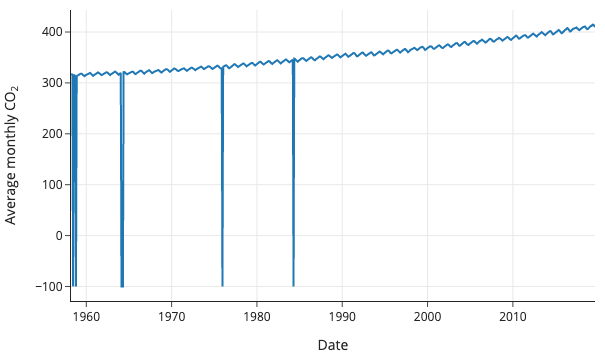

In [9]:
px.line(co2, x='DecDate', y='Avg', width=350, height=250,
        labels={'DecDate':'Date', 'Avg':'Average monthly CO<sub>2</sub>'})

Yikes! Plotting the data has uncovered a problem. The four dips in the line plot look odd. What happened here? We can check a few percentiles of the dataframe to see if we can spot the problem:

In [9]:
co2.describe()[3:]

,Yr,Mo,DecDate,Avg,Int,Trend,days
min,1958.0,1.0,1958.21,-99.99,312.66,314.62,-1.0
25%,1973.0,4.0,1973.56,328.59,328.79,329.73,-1.0
50%,1988.0,6.0,1988.92,351.73,351.73,352.38,25.0
75%,2004.0,9.0,2004.27,377.00,377.00,377.18,28.0
max,2019.0,12.0,2019.62,414.66,414.66,411.84,31.0


This time, looking a bit more closely at the range of values, we see that some data have unusual values like `-1` and `-99.99`. If we read the information at the top of the file more carefully, we find that `-99.99` denotes a missing monthly average and `-1` signifies a missing value for the number of days the equipment was in operation that month. Even with relatively clean data, it's a good practice to read the documentation and make a few quality checks before jumping into the analysis stage. 

## Quality Checks

Let's step back for a moment and perform some quality checks. We might confirm that we have the expected number of observations; look for unusual values; and cross-check anomalies that we find to the values in other features. 

First, we consider the shape of the data. How many rows should we have? From looking at the head and tail of the dataframe, the data appear to be in chronological order, beginning with March 1958 and ending with August 2019.
This means we should have $ 12 \times (2019-1957) - 2 - 4 = 738 $ records, which we can check against the shape of the dataframe:

In [13]:
co2.shape

(738, 7)

Our calculations match the number of rows in the data table. 

Next, let's check the quality of the features, starting with `Mo`. We expect the values to range from 1 to 12, and each month should have 2019 – 1957 = 62  or 61 instances (since the recordings begin in March of the first year and end in August of the most recent year):

In [13]:
co2["Mo"].value_counts().reindex(range(1,13)).tolist()

[61, 61, 62, 62, 62, 62, 62, 62, 61, 61, 61, 61]

As expected, Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62. 

Now let's examine the column called `days` with a histogram:

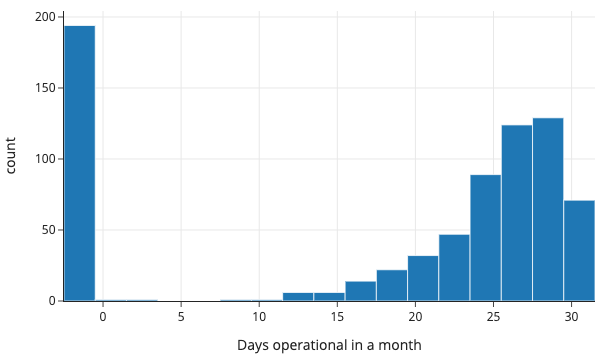

In [9]:
px.histogram(co2, x='days', width=350, height=250,
            labels={'days':'Days operational in a month'})

We see that a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values. A scatterplot can help us cross-check missing data against the year of the recording:

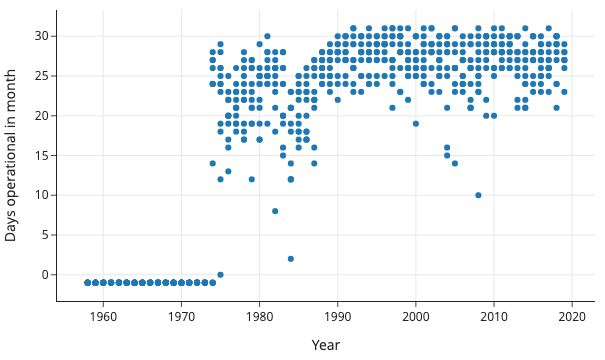

In [13]:
px.scatter(co2, x='Yr', y='days', width=350, height=250,
          labels={'Yr':'Year', 'days':'Days operational in month' })

The line along the bottom left of the plot shows us that all of the missing data are in the early years of operation. The number of days of operation of the equipment may not have been collected in the early days. It also appears that there might have been problems with the equipment in the mid- to late '80s. What do we do with these conjectures? We can try to confirm them by looking through documentation about the historical readings. If we are concerned about the impact on the CO<sub>2</sub> averages for records with missing values for the number of days of operation, then a simple solution would be to drop the earliest recordings. However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems with the CO<sub>2</sub> averages in those early days.

Next, let's return to the `-99.99` values for the average CO<sub>2</sub> measurement and begin our checks with a histogram:

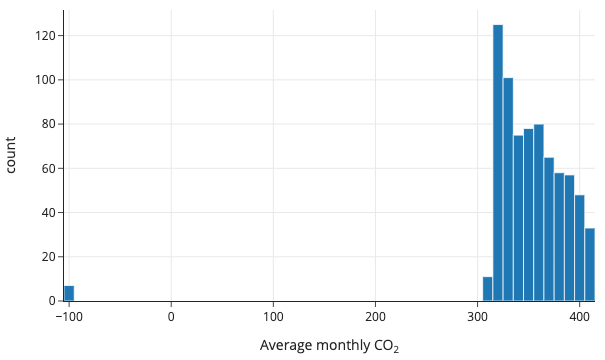

In [10]:
px.histogram(co2, x='Avg', width=350, height=250,
            labels={'Avg':'Average monthly CO<sub>2</sub>'})

The recorded values are in the 300–400 range, which is what we expect based on our research into CO<sub>2</sub> levels. We also see that there are only a few missing values. Since there aren't many missing values, we can examine all
of them:

In [18]:
co2[co2["Avg"] < 0]

,Yr,Mo,DecDate,Avg,Int,Trend,days
3,1958,6,1958.46,-99.99,317.10,314.85,-1
7,1958,10,1958.79,-99.99,312.66,315.61,-1
71,1964,2,1964.12,-99.99,320.07,319.61,-1
72,1964,3,1964.21,-99.99,320.73,319.55,-1
73,1964,4,1964.29,-99.99,321.77,319.48,-1
213,1975,12,1975.96,-99.99,330.59,331.60,0
313,1984,4,1984.29,-99.99,346.84,344.27,2


We are faced with the question of what to do with the `-99.99` values. We have seen already the problems of leaving these values as is in a line plot. There are several options, and we describe them next.

## Addressing Missing Data 

The `-99.99`s for average CO<sub>2</sub> levels indicate missing recordings. These interfere with our statistical summaries and plots. It's good to know which values are missing, but we need to do something about them. We might drop those records, replace `-99.99` with `NaN`, or substitute `99.99` with a likely value for the average CO<sub>2</sub>. Let's examine each of these three options.

Note that the table already comes with a substitute value for the `-99.99`.  The column labeled `Int` has values that exactly match those in `Avg`, except when `Avg` is `-99.99`, and then a "reasonable" estimate is used instead.

To see the effect of each option, let's zoom in on a short time period—say the measurements in 1958—where we know we have two missing values. We can create a time-series plot for the three cases: drop the records with `-99.99`s (left plot); use `NaN` for missing values (middle plot); and substitute an estimate for `-99.99` (right plot). 

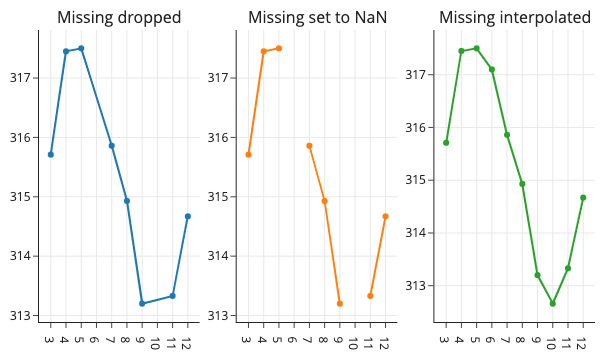

In [11]:
fig = make_subplots(rows=1, cols=3,
    subplot_titles=("Missing dropped", 
                    "Missing set to NaN", "Missing interpolated"))

co2_small = (co2[co2['Avg'] > 0])[:8] 

fig.add_trace(
    go.Scatter(x=co2_small['Mo'], y=co2_small['Avg'], 
               mode='lines+markers'),
    row=1, col=1)

co2_na = (co2.replace(-99.99, np.NaN))[:10]

fig.add_trace(
    go.Scatter(x=co2_na['Mo'], y=co2_na['Avg'], mode='lines+markers'),
    row=1, col=2)

fig.add_trace(
    go.Scatter(x=co2_na['Mo'], y=co2_na['Int'], mode='lines+markers'),
    row=1, col=3)

fig.update_xaxes(tickvals = np.arange(3, 13, 1), row=1, col=1)
fig.update_xaxes(tickvals = np.arange(3, 13, 1), row=1, col=2)
fig.update_xaxes(tickvals = np.arange(3, 13, 1), row=1, col=3)

fig.update_layout(height=250, width=550, showlegend=False, margin=dict(t=30))

fig.show()

When we look closely, we can see the difference between each of these plots. The leftmost plot
connects dots across a two-month time period, rather than one month.  In the
middle plot, the line breaks where the data are missing, and on the right, we can
see that months 6 and 10 now have values. In the big picture, since there are
only seven values missing from the 738 months, all of these options work.
However, there is some appeal to the right plot since the seasonal trends are
more cleanly discernible.     

The method used to interpolate the CO<sub>2</sub> measurements for the missing values is an averaging process that takes into consideration the month and year. The idea is to reflect both seasonal changes and the long-term trend. This technique is described in greater detail in the documentation at the top of the datafile.

These plots have shown the granularity of the data to be monthly measurements, but other granularity options are available to us. We discuss this next. 

## Reshaping the Data Table

The CO<sub>2</sub> measurements taken at the Mauna Loa Observatory are also available both daily and hourly. The hourly data has a *finer granularity* than the daily data; and reciprocally, the daily data is *coarser* than the hourly data. 

Why not always just use the data with the finest granularity available? On a computational level, fine-grained data can become quite large. The Mauna Loa Observatory started recording CO<sub>2</sub> levels in 1958. Imagine how many rows the data table would contain if they provided measurements every single second! But more importantly, we want the granularity of the data to match our research question. Suppose we want to see whether CO<sub>2</sub> levels have risen over the past 50+ years, consistent with global warming predictions. We don’t need a CO<sub>2</sub> measurement every second. In fact, we might well be content with yearly averages where the seasonal patterns are smoothed away. We can aggregate the monthly measurements, changing the granularity to annual averages, and make a plot to display the general trend.
We can use *aggregation* to go to a coarser granularity—in `pandas`, we use `.groupby()` and `.agg()`:

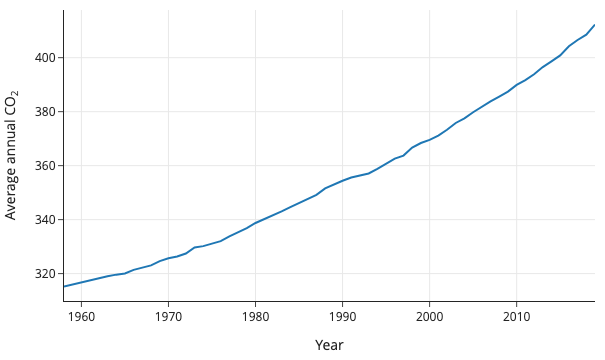

In [13]:
co2_ann = co2.groupby('Yr')['Int'].mean().reset_index()
px.line(co2_ann, x='Yr', y='Int', height=250, width=350,
       labels={'Yr':'Year', 'Int':'Average annual CO<sub>2</sub>' })

Indeed, we see a rise by nearly 100 ppm of CO<sub>2</sub> since Mauna Loa began recording in 1958.

To recap, after reading the whitespace-separated, plain-text file into a dataframe, we began to check its quality.  We used the scope and context of the data to affirm that its shape matched the range of dates of collection. We confirmed that the values and counts for the month were as expected. We ascertained the extent of missing values in the features, and we looked for connections between missing values and other features. We considered three approaches to handling the missing data: drop records, work with `NaN` values, and impute values to have a full table. And, finally, we changed the granularity of the dataframe by rolling it up from a monthly to an annual average. This change in granularity removed seasonal fluctuations and focused on the long term trend in the level of CO<sub>2</sub> in the atmosphere. The next four sections of this chapter expand on these actions to wrangle data into a form suitable for analysis: quality checks, missing value treatments, transformations, and shape adjustments. We begin with quality checks.